# Automated Essay Scoring with Transformers

This notebook implements a transformer architechture for automated essay scoring using two BERT models to encode the prompts and essays seperately.

## Key Findings

In summary, the cross-attention two-BERT model has proven to be highly effective for automated essay scoring. With an accuracy of 81% across different score levels and strong performance metrics, it's clear that this model does a great job of understanding the connection between writing prompts and the quality of the essays.

- **Regression Outperforms Classification:** Interpreting the essay scoring task as a regression problem (predicting continuous scores) led to significantly better results than treating it as a classification task. Regression provided more stable training and more accurate predictions, especially for intermediate scores.

- **CLS Token is Superior to Pooling:** Using the `[CLS]` token output from BERT as the essay/prompt representation consistently outperformed approaches that pooled the entire output sequence. The `[CLS]` embedding captured the most relevant information for scoring.

- **Class Balancing is Crucial:** Balancing the class distribution in the training data through random oversampling was essential for robust model performance. Without this step, the model tended to overfit to the most common score ranges and underperformed on minority classes.

- **Learning Rate Scheduling Matters:** Incorporating learning rate scheduling (with warmup and linear decay) led to much more stable training and significantly improved final performance, helping the model converge more effectively.

- **Hyperparameter Sensitivity in the Final Model:** The final two-BERT essay scorer with cross-attention is sensitive to hyperparameter choices. The best results were achieved only after extensive hyperparameter tuning using Optuna for 50 iterations, highlighting the importance of careful optimization for this architecture.

# Imports and Device Setup

In [3]:
# Standard library
import os
from datetime import datetime
from math import ceil
import gc

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

# Transformers
from transformers import BertModel, BertTokenizer, get_scheduler

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

device = torch.device(
    "mps"
    if torch.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")

2025-06-18 08:25:28.104794: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 08:25:28.235648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750227928.285580    5256 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750227928.300290    5256 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750227928.414952    5256 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda


# Load and Prepare Data

---

Read the cleaned training and test datasets into pandas DataFrames.

In [4]:
train_file_path = "../data/clean_train.csv"
test_file_path = "../data/clean_test.csv"
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

## Preprocess Band Scores

Multiply band scores by 2, convert to integer, and shift the range to 0-10 for compatibility with CUDA.

In [5]:
train_df["band_score"] = train_df["band_score"] * 2
test_df["band_score"] = test_df["band_score"] * 2
train_df["band_score"] = train_df["band_score"].astype(int)
test_df["band_score"] = test_df["band_score"].astype(int)

# Subtract 8 from band_score to get the range 0-10 (this is needed for cuda)
train_df["band_score"] = train_df["band_score"] - 8
test_df["band_score"] = test_df["band_score"] - 8

## Split Data into Training and Validation Sets

Split the training data into training and validation sets using an 80/20 split.

In [6]:
# Splitting train into train and validation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"Train shape: {train_df.shape}")
print(f"Val shape: {val_df.shape}")

Train shape: (7238, 14)
Val shape: (1810, 14)


## Oversample Minority Classes


Apply random oversampling to balance the class distribution in the training set.

<Axes: xlabel='band_score'>

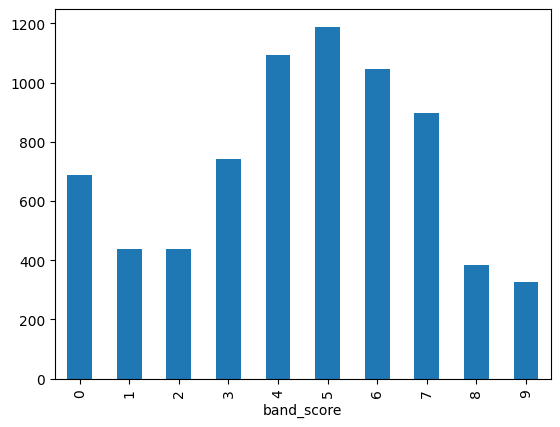

In [7]:
band_counts = train_df["band_score"].value_counts().sort_index()
band_counts.plot(kind="bar")

In [8]:
print("Before oversampling:")
print(f"Train shape: {train_df.shape}")
print(f"Train class distribution:\n{train_df['band_score'].value_counts().sort_index()}")

def random_oversample(df, target_column, random_state=42):
    """
    Randomly oversample minority classes to match the majority class
    Args:
        df (pd.DataFrame): The input DataFrame.
        target_column (str): The name of the target column.
        random_state (int): The random seed for reproducibility.

    Returns:
        pd.DataFrame: The oversampled DataFrame.
    """
    np.random.seed(random_state)

    # Get class counts
    class_counts = df["band_score"].value_counts()
    max_count = class_counts.max()

    oversampled_dfs = []

    for class_value in class_counts.index:
        class_df = df[df["band_score"] == class_value]
        current_count = len(class_df)

        if current_count < max_count:
            # Calculate how many more samples we need
            needed_samples = max_count - current_count

            # Randomly sample with replacement
            additional_samples = class_df.sample(
                n=needed_samples, replace=True, random_state=random_state
            )

            # Combine original and additional samples
            class_df_oversampled = pd.concat(
                [class_df, additional_samples], ignore_index=True
            )
        else:
            class_df_oversampled = class_df

        oversampled_dfs.append(class_df_oversampled)

    # Combine all classes
    result_df = pd.concat(oversampled_dfs, ignore_index=True)

    # Shuffle the dataset
    result_df = result_df.sample(frac=1, random_state=random_state).reset_index(
        drop=True
    )

    return result_df


# Apply oversampling to training data only
train_df = random_oversample(train_df, "band_score", random_state=42)

print("\nAfter oversampling:")
print(f"Train shape: {train_df.shape}")
print(
    f"Train class distribution:\n{train_df['band_score'].value_counts().sort_index()}"
)
print(f"Val shape: {val_df.shape}")

Before oversampling:
Train shape: (7238, 14)
Train class distribution:
band_score
0     689
1     438
2     437
3     741
4    1093
5    1189
6    1046
7     896
8     384
9     325
Name: count, dtype: int64

After oversampling:
Train shape: (11890, 14)
Train class distribution:
band_score
0    1189
1    1189
2    1189
3    1189
4    1189
5    1189
6    1189
7    1189
8    1189
9    1189
Name: count, dtype: int64
Val shape: (1810, 14)


<Axes: xlabel='band_score'>

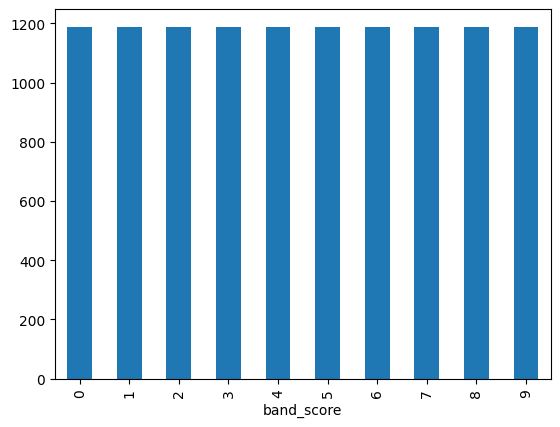

In [9]:
band_counts = train_df["band_score"].value_counts().sort_index()
band_counts.plot(kind="bar")

## Simple BERT Classifier as a Baseline

---

## Define Simple BERT Classification Dataset

Create a PyTorch Dataset class that concatenates prompts and essays for input to the model.

In [8]:
class SimpleClassificationDataset(Dataset):
    """
    A simple dataset that concatenates prompts and essays and uses them as a single input.
    """

    def __init__(self, dataframe):
        self.prompts = dataframe["prompt"].tolist()
        self.essays = dataframe["essay"].tolist()
        self.scores = dataframe["band_score"].tolist()

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        prompt = self.prompts[idx]
        essay = self.essays[idx]
        prompt_essay = prompt + ": " + essay
        score = torch.tensor(self.scores[idx], dtype=torch.long)
        return {"prompt_essay": prompt_essay, "score": score}

## Define Simple BERT Classification Model

Build a simple classification model using a pre-trained BERT encoder and a linear prediction head.

In [9]:
class SimpleClassificationModel(nn.Module):
    """
    A simple classification model that uses a BERT model to encode the prompt and essay,
    and then uses a linear layer to predict the score.
    """

    def __init__(
        self,
        bert_model_name="bert-base-cased",
        hidden_dim=256,
        output_dim=10,
        dropout_rate=0.1,
        pooling=False,
    ):
        """
        Args:
            bert_model_name (str): Name of the pre-trained BERT model to use from Hugging Face.
            hidden_dim (int): Dimension of the hidden layer in the prediction head.
            output_dim (int): Output dimension (1 for regression to a single score).
            dropout_rate (float): Dropout rate for regularization.
        """
        super(SimpleClassificationModel, self).__init__()

        self.pooling = pooling

        self.bert = BertModel.from_pretrained(bert_model_name)

        bert_output_dim = self.bert.config.hidden_size

        self.prediction_head = nn.Sequential(
            nn.Linear(bert_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim),
        )

        self.tokenizer = BertTokenizer.from_pretrained(bert_model_name)

    def forward(self, prompt_essay_batch, max_length=512):
        """
        Forward pass of the model.
        Args:
            prompt_essay (str): The prompt and essay concatenated together.
            max_length (int): The maximum length of the input sequence.

        Returns:
            torch.Tensor: The predicted scores.
        """
        inputs = self.tokenizer(
            prompt_essay_batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )

        # Move inputs to the same device as the model
        input_ids = inputs["input_ids"].to(self.bert.device)
        attention_mask = inputs["attention_mask"].to(self.bert.device)

        outputs = self.bert(input_ids, attention_mask=attention_mask)
        if self.pooling:
            outputs = outputs.pooler_output
        else:
            outputs = outputs.last_hidden_state[:, 0, :]  # CLS token

        logits = self.prediction_head(outputs)
        return logits

## Training and Evaluation Functions

Define functions for training the model with early stopping and for evaluating model performance.

In [10]:
def train_simple_classification_model(
    model: SimpleClassificationModel,
    train_dataloader: SimpleClassificationDataset,
    val_dataloader: SimpleClassificationDataset,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
    tensorboard_log_dir: str,
    checkpoint_dir: str,
    epochs: int,
    patience: int,
    delta: float,
    max_length: int = 512,
    warmup_ratio: float = 0.1,
) -> torch.nn.Module:
    """
    Train a simple regression model.

    Args:
        model: The model to train.
        train_dataloader: The training data loader.
        val_dataloader: The validation data loader.
        optimizer: The optimizer.
        criterion: The loss function.
        device: The device to run the model on.
        tensorboard_log_dir: The directory to save the tensorboard logs.
        checkpoint_dir: The directory to save the model checkpoints.
        epochs: The number of epochs to train.
        patience: The number of epochs to wait for improvement before stopping.
        delta: The minimum change to qualify as improvement.
        max_length: The maximum length of the input sequence.
        warmup_ratio: The ratio of warmup steps to total steps.

    Returns:
        torch.nn.Module: The trained model.
    """
    # Tensorboard setup
    os.makedirs(tensorboard_log_dir, exist_ok=True)
    writer = SummaryWriter(
        tensorboard_log_dir + "-" + datetime.now().strftime("%Y%m%d_%H%M%S")
    )
    print(f"TensorBoard logs will be saved to: {tensorboard_log_dir}")

    # Checkpoint directory setup
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Scheduler setup
    total_steps = len(train_dataloader) * epochs
    warmup_steps = ceil(total_steps * warmup_ratio)
    scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    # Early stopping variables
    best_eval_loss = float("inf")
    early_stopping_counter = 0
    best_model_path = None

    # Training loop
    print("Starting training...")
    global_step = 0
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for i, batch in enumerate(train_dataloader):
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i + 1}/{len(train_dataloader)}")
            optimizer.zero_grad()

            prompt_essay = batch["prompt_essay"]
            scores = batch["score"].to(device)

            predictions = model(prompt_essay, max_length=max_length)
            loss = criterion(predictions, scores)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()
            writer.add_scalar("Loss/train_batch", loss.item(), global_step)
            global_step += 1

            if (i + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item():.4f}")

        avg_train_loss = total_train_loss / len(train_dataloader)
        writer.add_scalar("Loss/train_epoch", avg_train_loss, epoch)
        print(f"Epoch {epoch + 1} - Avg Training Loss: {avg_train_loss:.4f}")

        # --- Evaluation Loop ---
        model.eval()
        total_eval_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                prompt_essay = batch["prompt_essay"]
                scores = batch["score"].to(device)

                predictions = model(prompt_essay, max_length=max_length)
                loss = criterion(predictions, scores)
                total_eval_loss += loss.item()

        avg_eval_loss = total_eval_loss / len(val_dataloader)
        writer.add_scalar("Loss/eval_epoch", avg_eval_loss, epoch)
        print(f"Epoch {epoch + 1} - Avg Evaluation Loss: {avg_eval_loss:.4f}")

        # Early stopping and checkpoint logic
        if avg_eval_loss < best_eval_loss - delta:
            print(
                f"Validation loss improved from {best_eval_loss:.4f} to {avg_eval_loss:.4f}"
            )
            best_eval_loss = avg_eval_loss
            early_stopping_counter = 0

            checkpoint_path = os.path.join(
                checkpoint_dir,
                f"model_epoch_{epoch + 1}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt",
            )
            torch.save(
                {
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "train_loss": avg_train_loss,
                    "eval_loss": avg_eval_loss,
                },
                checkpoint_path,
            )

            if best_model_path and os.path.exists(best_model_path):
                os.remove(best_model_path)
            best_model_path = checkpoint_path
            print(f"Model saved to {checkpoint_path}")
        else:
            early_stopping_counter += 1
            print(
                f"No improvement in validation loss. Counter: {early_stopping_counter}/{patience}"
            )
            if early_stopping_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break

    writer.close()
    return model


def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            prompt_essay = batch["prompt_essay"]
            labels = batch["score"].to(device)
            logits = model(prompt_essay)
            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return (
        accuracy_score(actual_labels, predictions),
        classification_report(actual_labels, predictions),
        confusion_matrix(actual_labels, predictions),
    )

## Set Hyperparameters

In [17]:
BERT_MODEL_NAME = "bert-base-cased"
LEARNING_RATE = 2e-5
EPOCHS = 10
BATCH_SIZE = 8
MAX_LENGTH = 512  # BERT max length
HIDDEN_DIM = 256
OUTPUT_DIM = 10
DROPOUT_RATE = 0.2
TENSORBOARD_LOG_DIR = "../runs/essay_scorer"
CHECKPOINT_DIR = "../checkpoints"
PATIENCE = 4  # Number of epochs to wait for improvement before stopping
DELTA = 0.001  # Minimum change to qualify as improvement
WARMUP_RATIO = 0.1

## Instantiate Model

In [12]:
model = SimpleClassificationModel(
    bert_model_name=BERT_MODEL_NAME,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout_rate=DROPOUT_RATE,
).to(device)

print(model)

SimpleClassificationModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Prepare DataLoaders and Train the Model

Monitor the training and validation loss for each epoch and batch. Model checkpoints are saved when validation loss improves.

In [13]:
train_dataset = SimpleClassificationDataset(train_df)
test_dataset = SimpleClassificationDataset(val_df)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Optimizer and Loss Function ---
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model = train_simple_classification_model(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    criterion,
    device,
    TENSORBOARD_LOG_DIR,
    CHECKPOINT_DIR,
    EPOCHS,
    PATIENCE,
    DELTA,
    MAX_LENGTH,
)

TensorBoard logs will be saved to: ../runs/essay_scorer
Starting training...
Epoch 1/10, Batch 1/1487
Epoch 1/10, Batch 2/1487
Epoch 1/10, Batch 3/1487
Epoch 1/10, Batch 4/1487
Epoch 1/10, Batch 5/1487
Epoch 1/10, Batch 6/1487
Epoch 1/10, Batch 7/1487
Epoch 1/10, Batch 8/1487
Epoch 1/10, Batch 9/1487
Epoch 1/10, Batch 10/1487
Epoch 1, Batch 10, Loss: 2.3115
Epoch 1/10, Batch 11/1487
Epoch 1/10, Batch 12/1487
Epoch 1/10, Batch 13/1487
Epoch 1/10, Batch 14/1487
Epoch 1/10, Batch 15/1487
Epoch 1/10, Batch 16/1487
Epoch 1/10, Batch 17/1487
Epoch 1/10, Batch 18/1487
Epoch 1/10, Batch 19/1487
Epoch 1/10, Batch 20/1487
Epoch 1, Batch 20, Loss: 2.3312
Epoch 1/10, Batch 21/1487
Epoch 1/10, Batch 22/1487
Epoch 1/10, Batch 23/1487
Epoch 1/10, Batch 24/1487
Epoch 1/10, Batch 25/1487
Epoch 1/10, Batch 26/1487
Epoch 1/10, Batch 27/1487
Epoch 1/10, Batch 28/1487
Epoch 1/10, Batch 29/1487
Epoch 1/10, Batch 30/1487
Epoch 1, Batch 30, Loss: 2.2613
Epoch 1/10, Batch 31/1487
Epoch 1/10, Batch 32/1487
Epoc

In [14]:
# Clear CUDA cache
del model
del train_dataloader
del val_dataloader
del train_dataset
del test_dataset
del criterion
gc.collect()
torch.cuda.empty_cache()

## Define Function for Plotting a Confusion Matrix

In [20]:
def confusion_matrix_plot(cm, num_classes):
    """
    Plot a confusion matrix.

    Args:
        cm (np.ndarray): The confusion matrix.
        num_classes (int): The number of classes.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[str(i) for i in range(num_classes)],
        yticklabels=[str(i) for i in range(num_classes)],
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

## Evaluate the Model

Evaluate the trained model on the test set to assess its performance.

Accuracy: 0.2775330396475771

 Report:
              precision    recall  f1-score   support

           0       0.44      0.89      0.59        46
           1       0.00      0.00      0.00        31
           2       0.00      0.00      0.00        20
           3       0.52      0.18      0.27        61
           4       0.33      0.25      0.29        67
           5       0.40      0.23      0.29        81
           6       0.07      0.05      0.05        65
           7       0.18      0.76      0.29        46
           8       0.00      0.00      0.00        21
           9       0.00      0.00      0.00        16

    accuracy                           0.28       454
   macro avg       0.19      0.24      0.18       454
weighted avg       0.26      0.28      0.23       454



/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

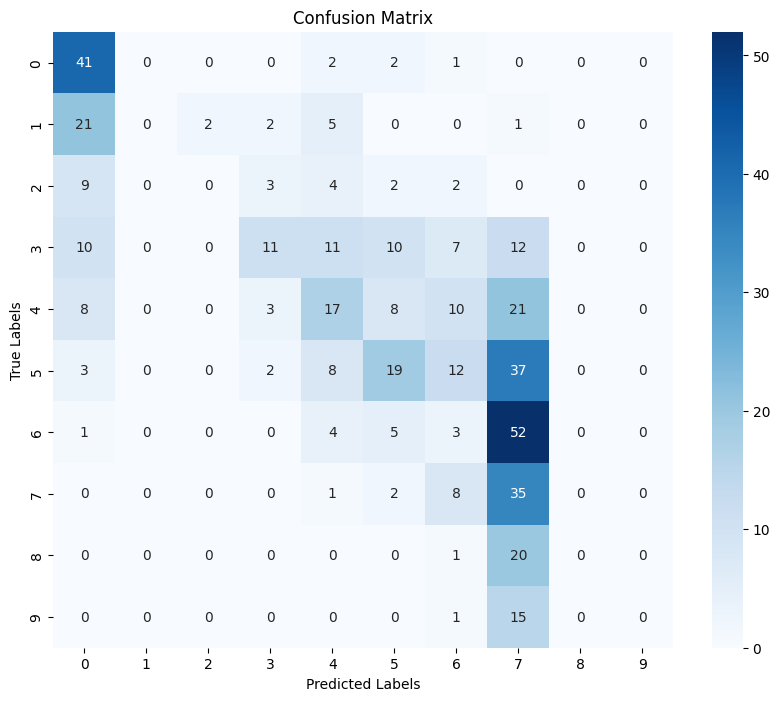

In [18]:
model = SimpleClassificationModel(
    bert_model_name=BERT_MODEL_NAME,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout_rate=DROPOUT_RATE,
).to(device)

# Load the best model checkpoint
model.load_state_dict(
    torch.load("../checkpoints/model_epoch_3_20250524_163703.pt")["model_state_dict"]
)

test_dataset = SimpleClassificationDataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
accuracy, report, cm = evaluate(model, test_dataloader, device)

print(f"Accuracy: {accuracy}")
print("\n Report:")
print(report)

confusion_matrix_plot(cm, OUTPUT_DIM)

# Experiment: Using CLS Token Instead of Pooler Output

---

Test whether using the CLS token representation performs better than the pooler output for classification.

In [19]:
model = SimpleClassificationModel(
    bert_model_name=BERT_MODEL_NAME,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout_rate=DROPOUT_RATE,
    pooling=False, # Use CLS token instead of pooler output
).to(device)

print(model)

SimpleClassificationModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Train Model with CLS Token

In [20]:
train_dataset = SimpleClassificationDataset(train_df)
test_dataset = SimpleClassificationDataset(val_df)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Optimizer and Loss Function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model = train_simple_classification_model(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    criterion,
    device,
    TENSORBOARD_LOG_DIR,
    CHECKPOINT_DIR,
    EPOCHS,
    PATIENCE,
    DELTA,
    MAX_LENGTH,
    WARMUP_RATIO,
)

TensorBoard logs will be saved to: ../runs/essay_scorer
Starting training...
Epoch 1/10, Batch 1/1487
Epoch 1/10, Batch 2/1487
Epoch 1/10, Batch 3/1487
Epoch 1/10, Batch 4/1487
Epoch 1/10, Batch 5/1487
Epoch 1/10, Batch 6/1487
Epoch 1/10, Batch 7/1487
Epoch 1/10, Batch 8/1487
Epoch 1/10, Batch 9/1487
Epoch 1/10, Batch 10/1487
Epoch 1, Batch 10, Loss: 2.3668
Epoch 1/10, Batch 11/1487
Epoch 1/10, Batch 12/1487
Epoch 1/10, Batch 13/1487
Epoch 1/10, Batch 14/1487
Epoch 1/10, Batch 15/1487
Epoch 1/10, Batch 16/1487
Epoch 1/10, Batch 17/1487
Epoch 1/10, Batch 18/1487
Epoch 1/10, Batch 19/1487
Epoch 1/10, Batch 20/1487
Epoch 1, Batch 20, Loss: 2.2682
Epoch 1/10, Batch 21/1487
Epoch 1/10, Batch 22/1487
Epoch 1/10, Batch 23/1487
Epoch 1/10, Batch 24/1487
Epoch 1/10, Batch 25/1487
Epoch 1/10, Batch 26/1487
Epoch 1/10, Batch 27/1487
Epoch 1/10, Batch 28/1487
Epoch 1/10, Batch 29/1487
Epoch 1/10, Batch 30/1487
Epoch 1, Batch 30, Loss: 2.3421
Epoch 1/10, Batch 31/1487
Epoch 1/10, Batch 32/1487
Epoc

In [21]:
# Clear CUDA cache
del model
del train_dataloader
del val_dataloader
del train_dataset
del test_dataset
del criterion
gc.collect()
torch.cuda.empty_cache()

## Evaluate CLS Token Model

Load the best CLS token model checkpoint and evaluate its performance on the test set.

Accuracy: 0.32599118942731276

 Report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69        46
           1       0.44      0.39      0.41        31
           2       0.24      0.40      0.30        20
           3       0.26      0.49      0.34        61
           4       0.16      0.10      0.13        67
           5       0.39      0.09      0.14        81
           6       0.31      0.25      0.28        65
           7       0.24      0.43      0.31        46
           8       0.53      0.38      0.44        21
           9       0.34      0.62      0.44        16

    accuracy                           0.33       454
   macro avg       0.37      0.38      0.35       454
weighted avg       0.35      0.33      0.31       454



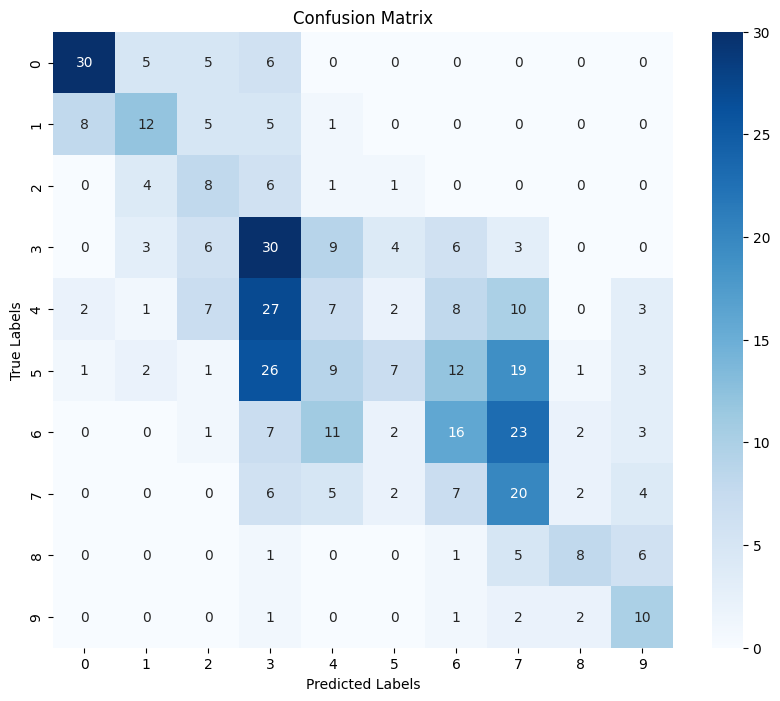

In [23]:
model = SimpleClassificationModel(
    bert_model_name=BERT_MODEL_NAME,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout_rate=DROPOUT_RATE,
    pooling=False,
).to(device)

# Load the best model checkpoint
model.load_state_dict(
    torch.load("../checkpoints/model_epoch_2_20250525_105035.pt")["model_state_dict"]
)

test_dataset = SimpleClassificationDataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
accuracy, report, cm = evaluate(model, test_dataloader, device)

print(f"Accuracy: {accuracy}")
print("\n Report:")
print(report)

confusion_matrix_plot(cm, OUTPUT_DIM)

# Experiment: Regression Approach

---

Switch from classification to regression by predicting continuous band scores instead of discrete classes.

## Define Regression Dataset

Create a dataset class for regression that returns float targets instead of integer class labels.

In [24]:
class SimpleRegressionDataset(Dataset):
    """
    A simple dataset that concatenates prompts and essays and uses them as a single input.
    """

    def __init__(self, dataframe):
        self.prompts = dataframe["prompt"].tolist()
        self.essays = dataframe["essay"].tolist()
        self.scores = dataframe["band_score"].tolist()

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        prompt = self.prompts[idx]
        essay = self.essays[idx]
        prompt_essay = prompt + ": " + essay
        score = torch.tensor(self.scores[idx], dtype=torch.float32)
        return {"prompt_essay": prompt_essay, "score": score}

## Regression Training and Evaluation Functions

Define specialized functions for training and evaluating regression models with metrics like MSE, MAE, RMSE, R², and Pearson correlation.

In [25]:
def train_simple_regression_model(
    model: SimpleClassificationModel,
    train_dataloader: SimpleClassificationDataset,
    val_dataloader: SimpleClassificationDataset,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
    tensorboard_log_dir: str,
    checkpoint_dir: str,
    epochs: int,
    patience: int,
    delta: float,
    max_length: int = 512,
    warmup_ratio: float = 0.1,
) -> torch.nn.Module:
    """
    Train a simple regression model.

    Args:
        model: The model to train.
        train_dataloader: The training data loader.
        val_dataloader: The validation data loader.
        optimizer: The optimizer.
        criterion: The loss function.
        device: The device to run the model on.
        tensorboard_log_dir: The directory to save the tensorboard logs.
        checkpoint_dir: The directory to save the model checkpoints.
        epochs: The number of epochs to train.
        patience: The number of epochs to wait for improvement before stopping.
        delta: The minimum change to qualify as improvement.
        max_length: The maximum length of the input sequence.
        warmup_ratio: The ratio of warmup steps to total steps.

    Returns:
        torch.nn.Module: The trained model.
    """
    
    # Tensorboard setup
    os.makedirs(tensorboard_log_dir, exist_ok=True)
    writer = SummaryWriter(
        tensorboard_log_dir + "-" + datetime.now().strftime("%Y%m%d_%H%M%S")
    )
    print(f"TensorBoard logs will be saved to: {tensorboard_log_dir}")

    # Checkpoint directory setup
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Scheduler setup
    total_steps = len(train_dataloader) * epochs
    warmup_steps = ceil(total_steps * warmup_ratio)
    scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    # Early stopping variables
    best_eval_loss = float("inf")
    early_stopping_counter = 0
    best_model_path = None

    # Training loop
    print("Starting training...")
    global_step = 0
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for i, batch in enumerate(train_dataloader):
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i + 1}/{len(train_dataloader)}")
            optimizer.zero_grad()

            prompt_essay = batch["prompt_essay"]
            scores = batch["score"].to(device)

            predictions = model(prompt_essay, max_length=max_length)
            predictions = predictions.squeeze()
            loss = criterion(predictions, scores)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()
            writer.add_scalar("Loss/train_batch", loss.item(), global_step)
            global_step += 1

            if (i + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item():.4f}")

        avg_train_loss = total_train_loss / len(train_dataloader)
        writer.add_scalar("Loss/train_epoch", avg_train_loss, epoch)
        print(f"Epoch {epoch + 1} - Avg Training Loss: {avg_train_loss:.4f}")

        # --- Evaluation Loop ---
        # Use the evaluate function for metrics
        mse, mae, rmse, r2, pearson_corr = evaluate_regression(
            model, val_dataloader, device, max_length
        )

        # Still need to calculate loss for early stopping
        model.eval()
        total_eval_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                prompt_essay = batch["prompt_essay"]
                scores = batch["score"].to(device)

                predictions = model(prompt_essay, max_length=max_length)
                predictions = predictions.squeeze()
                loss = criterion(predictions, scores)
                total_eval_loss += loss.item()

        avg_eval_loss = total_eval_loss / len(val_dataloader)

        # Log metrics to tensorboard
        writer.add_scalar("Loss/eval_epoch", avg_eval_loss, epoch)
        writer.add_scalar("MSE/eval_epoch", mse, epoch)
        writer.add_scalar("MAE/eval_epoch", mae, epoch)
        writer.add_scalar("RMSE/eval_epoch", rmse, epoch)
        writer.add_scalar("R2/eval_epoch", r2, epoch)
        writer.add_scalar("Pearson_Correlation/eval_epoch", pearson_corr, epoch)

        print(f"Epoch {epoch + 1} - Avg Evaluation Loss: {avg_eval_loss:.4f}")
        print(f"Epoch {epoch + 1} - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
        print(
            f"Epoch {epoch + 1} - R²: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}"
        )

        # Early stopping and checkpoint logic
        if avg_eval_loss < best_eval_loss - delta:
            print(
                f"Validation loss improved from {best_eval_loss:.4f} to {avg_eval_loss:.4f}"
            )
            best_eval_loss = avg_eval_loss
            early_stopping_counter = 0

            checkpoint_path = os.path.join(
                checkpoint_dir,
                f"model_epoch_{epoch + 1}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt",
            )
            torch.save(
                {
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "train_loss": avg_train_loss,
                    "eval_loss": avg_eval_loss,
                    "mse": mse,
                    "mae": mae,
                    "rmse": rmse,
                    "r2": r2,
                    "pearson_corr": pearson_corr,
                },
                checkpoint_path,
            )

            if best_model_path and os.path.exists(best_model_path):
                os.remove(best_model_path)
            best_model_path = checkpoint_path
            print(f"Model saved to {checkpoint_path}")
        else:
            early_stopping_counter += 1
            print(
                f"No improvement in validation loss. Counter: {early_stopping_counter}/{patience}"
            )
            if early_stopping_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break

    writer.close()
    return model


def evaluate_regression(model, data_loader, device, max_length=512):
    """
    Evaluate a regression model and return various regression metrics.

    Returns:
        tuple: (mse, mae, rmse, r2_score, pearson_correlation)
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from scipy.stats import pearsonr
    import numpy as np

    model.eval()
    predictions = []
    actual_scores = []

    with torch.no_grad():
        for batch in data_loader:
            prompt_essay = batch["prompt_essay"]
            scores = batch["score"].to(device)

            # Get model predictions
            preds = model(prompt_essay, max_length=max_length)

            # Squeeze predictions to remove extra dimensions
            preds = preds.squeeze()
            scores = scores.squeeze()

            # Convert to CPU and handle single item batches
            preds = preds.cpu().tolist()
            scores = scores.cpu().tolist()

            # Handle single item batches
            if isinstance(preds, float):
                preds = [preds]
            if isinstance(scores, float):
                scores = [scores]

            predictions.extend(preds)
            actual_scores.extend(scores)

    # Convert to numpy arrays for easier computation
    predictions = np.array(predictions)
    actual_scores = np.array(actual_scores)

    # Calculate regression metrics
    mse = mean_squared_error(actual_scores, predictions)
    mae = mean_absolute_error(actual_scores, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_scores, predictions)

    # Calculate Pearson correlation coefficient
    pearson_corr, _ = pearsonr(actual_scores, predictions)

    return mse, mae, rmse, r2, pearson_corr

In [26]:
BERT_MODEL_NAME = "bert-base-cased"
LEARNING_RATE = 2e-5
EPOCHS = 10
BATCH_SIZE = 8
MAX_LENGTH = 512  # BERT max length
HIDDEN_DIM = 512
OUTPUT_DIM = 1
DROPOUT_RATE = 0.2
TENSORBOARD_LOG_DIR = "../runs/essay_scorer"
CHECKPOINT_DIR = "../checkpoints"
PATIENCE = 4  # Number of epochs to wait for improvement before stopping
DELTA = 0.001  # Minimum change to qualify as improvement
WARMUP_RATIO = 0.1

## Train Regression Model

Train the BERT model using regression with MSE loss and monitor various regression metrics.

In [27]:
# Create datasets
train_dataset = SimpleRegressionDataset(train_df)
val_dataset = SimpleRegressionDataset(val_df)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model and optimizer
model = SimpleClassificationModel(
    bert_model_name=BERT_MODEL_NAME,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout_rate=DROPOUT_RATE,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()

# Train
trained_model = train_simple_regression_model(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    tensorboard_log_dir=TENSORBOARD_LOG_DIR,
    checkpoint_dir=CHECKPOINT_DIR,
    epochs=EPOCHS,
    patience=PATIENCE,
    delta=DELTA,
    max_length=MAX_LENGTH,
    warmup_ratio=WARMUP_RATIO,
)

TensorBoard logs will be saved to: ../runs/essay_scorer
Starting training...
Epoch 1/10, Batch 1/1487
Epoch 1/10, Batch 2/1487
Epoch 1/10, Batch 3/1487
Epoch 1/10, Batch 4/1487
Epoch 1/10, Batch 5/1487
Epoch 1/10, Batch 6/1487
Epoch 1/10, Batch 7/1487
Epoch 1/10, Batch 8/1487
Epoch 1/10, Batch 9/1487
Epoch 1/10, Batch 10/1487
Epoch 1, Batch 10, Loss: 13.1055
Epoch 1/10, Batch 11/1487
Epoch 1/10, Batch 12/1487
Epoch 1/10, Batch 13/1487
Epoch 1/10, Batch 14/1487
Epoch 1/10, Batch 15/1487
Epoch 1/10, Batch 16/1487
Epoch 1/10, Batch 17/1487
Epoch 1/10, Batch 18/1487
Epoch 1/10, Batch 19/1487
Epoch 1/10, Batch 20/1487
Epoch 1, Batch 20, Loss: 20.5513
Epoch 1/10, Batch 21/1487
Epoch 1/10, Batch 22/1487
Epoch 1/10, Batch 23/1487
Epoch 1/10, Batch 24/1487
Epoch 1/10, Batch 25/1487
Epoch 1/10, Batch 26/1487
Epoch 1/10, Batch 27/1487
Epoch 1/10, Batch 28/1487
Epoch 1/10, Batch 29/1487
Epoch 1/10, Batch 30/1487
Epoch 1, Batch 30, Loss: 25.9480
Epoch 1/10, Batch 31/1487
Epoch 1/10, Batch 32/1487
E

In [28]:
# Clear CUDA cache
del model
del train_loader
del val_loader
del train_dataset
del test_dataset
del criterion
del optimizer
gc.collect()
torch.cuda.empty_cache()

## Evaluate Regression Model as Classification

Convert regression predictions to integers and evaluate as a classification problem for comparison.

In [29]:
def evaluate_regression_as_classification(model, data_loader, device, max_length=512):
    """
    Evaluate a regression model by converting predictions to integers
    and treating them as classification labels.

    Args:
        model: The model to evaluate.
        data_loader: The data loader to use for evaluation.
        device: The device to run the model on.
        max_length: The maximum length of the input sequence.

    Returns:
        tuple: (accuracy, classification_report, confusion_matrix)
    """
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in data_loader:
            prompt_essay = batch["prompt_essay"]
            labels = batch["score"].to(device)

            # Get regression predictions (continuous values)
            preds = model(prompt_essay, max_length=max_length)
            preds = preds.squeeze()  # Remove extra dimensions

            # Convert continuous predictions to integers (round to nearest integer)
            preds_int = torch.round(preds).int()

            # Convert actual scores to integers as well
            labels_int = torch.round(labels).int()

            # Convert to CPU and extend lists
            predictions.extend(preds_int.cpu().tolist())
            actual_labels.extend(labels_int.cpu().tolist())

    # Calculate classification metrics
    accuracy = accuracy_score(actual_labels, predictions)
    class_report = classification_report(actual_labels, predictions)
    conf_matrix = confusion_matrix(actual_labels, predictions)

    return accuracy, class_report, conf_matrix

Accuracy: 0.5748898678414097

 Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        46
           1       0.62      0.65      0.63        31
           2       0.53      0.50      0.51        20
           3       0.68      0.66      0.67        61
           4       0.59      0.49      0.54        67
           5       0.63      0.65      0.64        81
           6       0.49      0.48      0.48        65
           7       0.52      0.59      0.55        46
           8       0.26      0.24      0.25        21
           9       0.35      0.44      0.39        16
          10       0.00      0.00      0.00         0

    accuracy                           0.57       454
   macro avg       0.50      0.50      0.50       454
weighted avg       0.58      0.57      0.58       454



/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

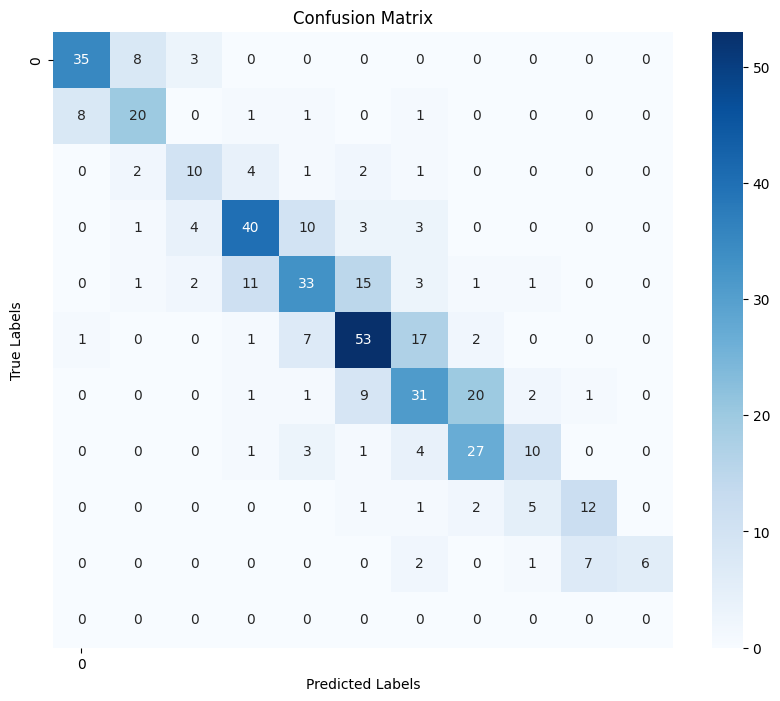

In [30]:
model = SimpleClassificationModel(
    bert_model_name=BERT_MODEL_NAME,
    hidden_dim=512,
    output_dim=1,
    dropout_rate=DROPOUT_RATE,
    pooling=False,
).to(device)

# Load the best model checkpoint
model.load_state_dict(
    torch.load("../checkpoints/model_epoch_7_20250525_124058.pt", weights_only=False)[
        "model_state_dict"
    ]
)
test_dataset = SimpleRegressionDataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
accuracy, report, cm = evaluate_regression_as_classification(
    model, test_dataloader, device
)

print(f"Accuracy: {accuracy}")
print("\n Report:")
print(report)

confusion_matrix_plot(cm, OUTPUT_DIM)

# Two-BERT Architecture

---

Implement a dual-BERT architecture that separately encodes prompts and essays before combining their representations.

## Define Separate Prompt-Essay Dataset

Create a dataset that keeps prompts and essays separate for the dual-BERT architecture.

In [16]:
class EssayDataset(Dataset):
    """
    A dataset that keeps prompts and essays separate for the dual-BERT architecture.
    """
    
    def __init__(self, dataframe):
        self.prompts = dataframe["prompt"].tolist()
        self.essays = dataframe["essay"].tolist()
        self.scores = dataframe["band_score"].tolist()

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        prompt = self.prompts[idx]
        essay = self.essays[idx]
        score = torch.tensor(self.scores[idx], dtype=torch.float32)
        return {"prompt": prompt, "essay": essay, "score": score}

## Define Two-BERT Model Architecture

Implement a model with separate BERT encoders for prompts and essays, concatenating their CLS token representations.

In [18]:
class TwoBertEssayScorer(nn.Module):
    def __init__(
        self,
        bert_model_name="bert-base-cased",
        hidden_dim=256,
        output_dim=1,
        dropout_rate=0.1,
    ):
        """
        Args:
            bert_model_name (str): Name of the pre-trained BERT model to use from Hugging Face.
            hidden_dim (int): Dimension of the hidden layer in the prediction head.
            output_dim (int): Output dimension (1 for regression to a single score).
            dropout_rate (float): Dropout rate for regularization.
        """
        super(TwoBertEssayScorer, self).__init__()

        self.prompt_bert = BertModel.from_pretrained(bert_model_name)
        self.essay_bert = BertModel.from_pretrained(bert_model_name)

        bert_output_dim = self.prompt_bert.config.hidden_size

        self.prediction_head = nn.Sequential(
            nn.Linear(bert_output_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim),
        )

        self.tokenizer = BertTokenizer.from_pretrained(bert_model_name)

    def forward(self, prompt_texts, essay_texts, max_length=512):
        """
        Forward pass of the model.

        Args:
            prompt_texts (list of str): A batch of essay prompts.
            essay_texts (list of str): A batch of essays.
            max_length (int): Maximum sequence length for BERT tokenization.

        Returns:
            torch.Tensor: The predicted scores.
        """
        # Tokenize prompts
        prompt_inputs = self.tokenizer(
            prompt_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        # Move tokenized inputs to the same device as the model
        prompt_input_ids = prompt_inputs["input_ids"].to(self.prompt_bert.device)
        prompt_attention_mask = prompt_inputs["attention_mask"].to(
            self.prompt_bert.device
        )

        # Get prompt embeddings
        # We'll use the [CLS] token's output as the representation of the prompt
        prompt_outputs = self.prompt_bert(
            input_ids=prompt_input_ids, attention_mask=prompt_attention_mask
        )
        prompt_embedding = prompt_outputs.last_hidden_state[
            :, 0, :
        ]  # [batch_size, bert_hidden_dim]

        # Tokenize essays
        essay_inputs = self.tokenizer(
            essay_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        # Move tokenized inputs to the same device as the model
        essay_input_ids = essay_inputs["input_ids"].to(self.essay_bert.device)
        essay_attention_mask = essay_inputs["attention_mask"].to(self.essay_bert.device)

        # Get essay embeddings
        essay_outputs = self.essay_bert(
            input_ids=essay_input_ids, attention_mask=essay_attention_mask
        )
        essay_embedding = essay_outputs.last_hidden_state[
            :, 0, :
        ]  # [batch_size, bert_hidden_dim]

        # Concatenate prompt and essay embeddings
        combined_embedding = torch.cat(
            (prompt_embedding, essay_embedding), dim=1
        )  # [batch_size, bert_hidden_dim * 2]

        # Pass through the prediction head
        scores = self.prediction_head(combined_embedding)

        return scores


def evaluate_regression(
    model: TwoBertEssayScorer,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device,
    max_length: int = 512,
):
    """
    Evaluate a regression model and return various regression metrics.

    Returns:
        tuple: (mse, mae, rmse, r2_score, pearson_correlation)
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from scipy.stats import pearsonr
    import numpy as np

    model.eval()
    predictions = []
    actual_scores = []

    with torch.no_grad():
        for batch in data_loader:
            prompt = batch["prompt"]
            essay = batch["essay"]
            labels = batch["score"].to(device)

            # Get regression predictions (continuous values)
            preds = model(prompt_texts=prompt, essay_texts=essay, max_length=max_length)
            preds = preds.squeeze()  # Remove extra dimensions

            # Convert to CPU and extend lists
            predictions.extend(preds.cpu().tolist())
            actual_scores.extend(labels.cpu().tolist())

    # Convert to numpy arrays for easier computation
    predictions = np.array(predictions)
    actual_scores = np.array(actual_scores)

    # Calculate regression metrics
    mse = mean_squared_error(actual_scores, predictions)
    mae = mean_absolute_error(actual_scores, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_scores, predictions)

    # Calculate Pearson correlation coefficient
    pearson_corr, _ = pearsonr(actual_scores, predictions)

    return mse, mae, rmse, r2, pearson_corr


def evaluate_regression_as_classification(
    model: TwoBertEssayScorer,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device,
    max_length: int = 512,
    min_score: int = 0,
    max_score: int = 10,
):
    """
    Evaluate regression model by converting predictions to integers for classification metrics.

    Args:
        model: The model to evaluate.
        data_loader: The data loader to use for evaluation.
        device: The device to run the model on.
        max_length: The maximum length of the input sequence.
        min_score: The minimum score.
        max_score: The maximum score.

    Returns:
        tuple: (accuracy, classification_report, confusion_matrix)
    """
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in data_loader:
            prompt = batch["prompt"]
            essay = batch["essay"]
            labels = batch["score"].to(device)

            # Get regression predictions
            preds = model(prompt_texts=prompt, essay_texts=essay, max_length=max_length)
            preds = preds.squeeze()

            # Convert to integers with clipping
            preds_clipped = torch.clamp(preds, min=min_score, max=max_score)
            preds_int = torch.round(preds_clipped).int()

            labels_clipped = torch.clamp(labels, min=min_score, max=max_score)
            labels_int = torch.round(labels_clipped).int()

            predictions.extend(preds_int.cpu().tolist())
            actual_labels.extend(labels_int.cpu().tolist())

    # Calculate classification metrics
    accuracy = accuracy_score(actual_labels, predictions)
    class_report = classification_report(actual_labels, predictions)
    conf_matrix = confusion_matrix(actual_labels, predictions)

    return accuracy, class_report, conf_matrix

## Enhanced Training Function for Two-BERT Models

In [33]:
def train_regression_model(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
    tensorboard_log_dir: str,
    checkpoint_dir: str,
    epochs: int,
    patience: int,
    delta: float,
    max_length: int = 512,
    warmup_ratio: float = 0.1,
) -> torch.nn.Module:
    """
    Train a regression model.

    Args:
        model: The model to train.
        train_dataloader: The training data loader.
        val_dataloader: The validation data loader.
        optimizer: The optimizer.
        criterion: The loss function.
        device: The device to run the model on.
        tensorboard_log_dir: The directory to save the tensorboard logs.
        checkpoint_dir: The directory to save the model checkpoints.
        epochs: The number of epochs to train.
        patience: The number of epochs to wait for improvement before stopping.
        delta: The minimum change to qualify as improvement.
        max_length: The maximum length of the input sequence.
        warmup_ratio: The ratio of warmup steps to total steps.

    Returns:
        torch.nn.Module: The trained model.
    """

    # Tensorboard setup
    os.makedirs(tensorboard_log_dir, exist_ok=True)
    writer = SummaryWriter(
        tensorboard_log_dir + "-" + datetime.now().strftime("%Y%m%d_%H%M%S")
    )
    print(f"TensorBoard logs will be saved to: {tensorboard_log_dir}")

    # Checkpoint directory setup
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Scheduler setup
    total_steps = len(train_dataloader) * epochs
    warmup_steps = ceil(total_steps * warmup_ratio)
    scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    # Early stopping variables
    best_eval_loss = float("inf")
    early_stopping_counter = 0
    best_model_path = None

    # Training loop
    print("Starting training...")
    global_step = 0
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for i, batch in enumerate(train_dataloader):
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i + 1}/{len(train_dataloader)}")
            optimizer.zero_grad()

            prompts = batch["prompt"]
            essays = batch["essay"]
            scores = batch["score"].to(device)

            # Forward pass
            predictions = model(
                prompt_texts=prompts, essay_texts=essays, max_length=max_length
            )
            predictions = predictions.squeeze()

            loss = criterion(predictions, scores)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

            writer.add_scalar("Loss/train_batch", loss.item(), global_step)
            global_step += 1

            if (i + 1) % 10 == 0:
                print(
                    f"Epoch {epoch + 1}/{epochs}, Batch {i + 1}/{len(train_dataloader)}, Loss: {loss.item():.4f}"
                )

        avg_train_loss = total_train_loss / len(train_dataloader)
        writer.add_scalar("Loss/train_epoch", avg_train_loss, epoch)
        print(
            f"Epoch {epoch + 1}/{epochs} - Average Training Loss: {avg_train_loss:.4f}"
        )

        # --- Evaluation Loop ---
        # Get regression metrics
        mse, mae, rmse, r2, pearson_corr = evaluate_regression(
            model, val_dataloader, device, max_length
        )

        # Also get classification metrics for comparison
        accuracy, class_report, conf_matrix = evaluate_regression_as_classification(
            model, val_dataloader, device, max_length
        )

        # Calculate validation loss for early stopping
        model.eval()
        total_eval_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                prompts = batch["prompt"]
                essays = batch["essay"]
                scores = batch["score"].to(device)

                predictions = model(
                    prompt_texts=prompts, essay_texts=essays, max_length=max_length
                )
                predictions = predictions.squeeze()
                loss = criterion(predictions, scores)
                total_eval_loss += loss.item()

        avg_eval_loss = total_eval_loss / len(val_dataloader)

        # Log all metrics to tensorboard
        writer.add_scalar("Loss/eval_epoch", avg_eval_loss, epoch)
        writer.add_scalar("MSE/eval_epoch", mse, epoch)
        writer.add_scalar("MAE/eval_epoch", mae, epoch)
        writer.add_scalar("RMSE/eval_epoch", rmse, epoch)
        writer.add_scalar("R2/eval_epoch", r2, epoch)
        writer.add_scalar("Pearson_Correlation/eval_epoch", pearson_corr, epoch)
        writer.add_scalar("Accuracy/eval_epoch", accuracy, epoch)

        print(
            f"Epoch {epoch + 1}/{epochs} - Average Evaluation Loss: {avg_eval_loss:.4f}"
        )
        print(
            f"Epoch {epoch + 1}/{epochs} - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}"
        )
        print(
            f"Epoch {epoch + 1}/{epochs} - R²: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}"
        )
        print(f"Epoch {epoch + 1}/{epochs} - Classification Accuracy: {accuracy:.4f}")

        # Early stopping and model checkpoint logic
        if avg_eval_loss < best_eval_loss - delta:
            print(
                f"Validation loss improved from {best_eval_loss:.4f} to {avg_eval_loss:.4f}"
            )
            best_eval_loss = avg_eval_loss
            early_stopping_counter = 0

            # Save the model
            checkpoint_path = os.path.join(
                checkpoint_dir,
                f"model_epoch_{epoch + 1}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt",
            )
            torch.save(
                {
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "train_loss": avg_train_loss,
                    "eval_loss": avg_eval_loss,
                    "mse": mse,
                    "mae": mae,
                    "rmse": rmse,
                    "r2": r2,
                    "pearson_corr": pearson_corr,
                    "accuracy": accuracy,
                },
                checkpoint_path,
            )

            if best_model_path and os.path.exists(best_model_path):
                os.remove(best_model_path)
            best_model_path = checkpoint_path
            print(f"Model saved to {checkpoint_path}")
        else:
            early_stopping_counter += 1
            print(
                f"No improvement in validation loss. Counter: {early_stopping_counter}/{patience}"
            )

            if early_stopping_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break

    writer.close()
    return model

In [12]:
BERT_MODEL_NAME = "bert-base-cased"
LEARNING_RATE = 2e-5
EPOCHS = 10
BATCH_SIZE = 8
MAX_LENGTH = 512  # BERT max length
HIDDEN_DIM = 512
OUTPUT_DIM = 1
DROPOUT_RATE = 0.2
TENSORBOARD_LOG_DIR = "../runs/essay_scorer"
CHECKPOINT_DIR = "../checkpoints"
PATIENCE = 4  # Number of epochs to wait for improvement before stopping
DELTA = 0.001  # Minimum change to qualify as improvement
WARMUP_RATIO = 0.1

In [35]:
model = TwoBertEssayScorer(
    bert_model_name=BERT_MODEL_NAME,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout_rate=DROPOUT_RATE,
).to(device)

print(model)

TwoBertEssayScorer(
  (prompt_bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Train Two-BERT Model

Train the dual-BERT architecture and monitor both regression and classification metrics.

In [36]:
# Create datasets
train_dataset = EssayDataset(train_df)
val_dataset = EssayDataset(val_df)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()

# Train
trained_model = train_regression_model(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    tensorboard_log_dir=TENSORBOARD_LOG_DIR,
    checkpoint_dir=CHECKPOINT_DIR,
    epochs=EPOCHS,
    patience=PATIENCE,
    delta=DELTA,
    max_length=MAX_LENGTH,
    warmup_ratio=WARMUP_RATIO,
)

TensorBoard logs will be saved to: ../runs/essay_scorer
Starting training...
Epoch 1/10, Batch 1/1487
Epoch 1/10, Batch 2/1487
Epoch 1/10, Batch 3/1487
Epoch 1/10, Batch 4/1487
Epoch 1/10, Batch 5/1487
Epoch 1/10, Batch 6/1487
Epoch 1/10, Batch 7/1487
Epoch 1/10, Batch 8/1487
Epoch 1/10, Batch 9/1487
Epoch 1/10, Batch 10/1487
Epoch 1/10, Batch 10/1487, Loss: 39.6118
Epoch 1/10, Batch 11/1487
Epoch 1/10, Batch 12/1487
Epoch 1/10, Batch 13/1487
Epoch 1/10, Batch 14/1487
Epoch 1/10, Batch 15/1487
Epoch 1/10, Batch 16/1487
Epoch 1/10, Batch 17/1487
Epoch 1/10, Batch 18/1487
Epoch 1/10, Batch 19/1487
Epoch 1/10, Batch 20/1487
Epoch 1/10, Batch 20/1487, Loss: 28.0331
Epoch 1/10, Batch 21/1487
Epoch 1/10, Batch 22/1487
Epoch 1/10, Batch 23/1487
Epoch 1/10, Batch 24/1487
Epoch 1/10, Batch 25/1487
Epoch 1/10, Batch 26/1487
Epoch 1/10, Batch 27/1487
Epoch 1/10, Batch 28/1487
Epoch 1/10, Batch 29/1487
Epoch 1/10, Batch 30/1487
Epoch 1/10, Batch 30/1487, Loss: 18.5797
Epoch 1/10, Batch 31/1487
Epo

/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Epoch 1/10 - Average Evaluation Loss: 5.4835
Epoch 1/10 - MSE: 5.4639, MAE: 1.8313, RMSE: 2.3375
Epoch 1/10 - R²: 0.0867, Pearson Correlation: 0.6001
Epoch 1/10 - Classification Accuracy: 0.1856
Validation loss improved from inf to 5.4835
Model saved to ../checkpoints/model_epoch_1_20250617_153016.pt
Epoch 2/10, Batch 1/1487
Epoch 2/10, Batch 2/1487
Epoch 2/10, Batch 3/1487
Epoch 2/10, Batch 4/1487
Epoch 2/10, Batch 5/1487
Epoch 2/10, Batch 6/1487
Epoch 2/10, Batch 7/1487
Epoch 2/10, Batch 8/1487
Epoch 2/10, Batch 9/1487
Epoch 2/10, Batch 10/1487
Epoch 2/10, Batch 10/1487, Loss: 2.0208
Epoch 2/10, Batch 11/1487
Epoch 2/10, Batch 12/1487
Epoch 2/10, Batch 13/1487
Epoch 2/10, Batch 14/1487
Epoch 2/10, Batch 15/1487
Epoch 2/10, Batch 16/1487
Epoch 2/10, Batch 17/1487
Epoch 2/10, Batch 18/1487
Epoch 2/10, Batch 19/1487
Epoch 2/10, Batch 20/1487
Epoch 2/10, Batch 20/1487, Loss: 1.8363
Epoch 2/10, Batch 21/1487
Epoch 2/10, Batch 22/1487
Epoch 2/10, Batch 23/1487
Epoch 2/10, Batch 24/1487
Epo

/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Epoch 2/10 - Average Evaluation Loss: 4.2149
Epoch 2/10 - MSE: 4.2127, MAE: 1.5873, RMSE: 2.0525
Epoch 2/10 - R²: 0.2958, Pearson Correlation: 0.6178
Epoch 2/10 - Classification Accuracy: 0.2271
Validation loss improved from 5.4835 to 4.2149
Model saved to ../checkpoints/model_epoch_2_20250617_154234.pt
Epoch 3/10, Batch 1/1487
Epoch 3/10, Batch 2/1487
Epoch 3/10, Batch 3/1487
Epoch 3/10, Batch 4/1487
Epoch 3/10, Batch 5/1487
Epoch 3/10, Batch 6/1487
Epoch 3/10, Batch 7/1487
Epoch 3/10, Batch 8/1487
Epoch 3/10, Batch 9/1487
Epoch 3/10, Batch 10/1487
Epoch 3/10, Batch 10/1487, Loss: 1.1734
Epoch 3/10, Batch 11/1487
Epoch 3/10, Batch 12/1487
Epoch 3/10, Batch 13/1487
Epoch 3/10, Batch 14/1487
Epoch 3/10, Batch 15/1487
Epoch 3/10, Batch 16/1487
Epoch 3/10, Batch 17/1487
Epoch 3/10, Batch 18/1487
Epoch 3/10, Batch 19/1487
Epoch 3/10, Batch 20/1487
Epoch 3/10, Batch 20/1487, Loss: 1.3812
Epoch 3/10, Batch 21/1487
Epoch 3/10, Batch 22/1487
Epoch 3/10, Batch 23/1487
Epoch 3/10, Batch 24/1487


/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

Epoch 5/10 - Average Evaluation Loss: 3.9284
Epoch 5/10 - MSE: 3.9236, MAE: 1.5043, RMSE: 1.9808
Epoch 5/10 - R²: 0.3441, Pearson Correlation: 0.6511
Epoch 5/10 - Classification Accuracy: 0.2453
No improvement in validation loss. Counter: 1/4
Epoch 6/10, Batch 1/1487
Epoch 6/10, Batch 2/1487
Epoch 6/10, Batch 3/1487
Epoch 6/10, Batch 4/1487
Epoch 6/10, Batch 5/1487
Epoch 6/10, Batch 6/1487
Epoch 6/10, Batch 7/1487
Epoch 6/10, Batch 8/1487
Epoch 6/10, Batch 9/1487
Epoch 6/10, Batch 10/1487
Epoch 6/10, Batch 10/1487, Loss: 0.1609
Epoch 6/10, Batch 11/1487
Epoch 6/10, Batch 12/1487
Epoch 6/10, Batch 13/1487
Epoch 6/10, Batch 14/1487
Epoch 6/10, Batch 15/1487
Epoch 6/10, Batch 16/1487
Epoch 6/10, Batch 17/1487
Epoch 6/10, Batch 18/1487
Epoch 6/10, Batch 19/1487
Epoch 6/10, Batch 20/1487
Epoch 6/10, Batch 20/1487, Loss: 0.2888
Epoch 6/10, Batch 21/1487
Epoch 6/10, Batch 22/1487
Epoch 6/10, Batch 23/1487
Epoch 6/10, Batch 24/1487
Epoch 6/10, Batch 25/1487
Epoch 6/10, Batch 26/1487
Epoch 6/10

/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

Epoch 6/10 - Average Evaluation Loss: 4.0813
Epoch 6/10 - MSE: 4.0801, MAE: 1.5251, RMSE: 2.0199
Epoch 6/10 - R²: 0.3180, Pearson Correlation: 0.6413
Epoch 6/10 - Classification Accuracy: 0.2569
No improvement in validation loss. Counter: 2/4
Epoch 7/10, Batch 1/1487
Epoch 7/10, Batch 2/1487
Epoch 7/10, Batch 3/1487
Epoch 7/10, Batch 4/1487
Epoch 7/10, Batch 5/1487
Epoch 7/10, Batch 6/1487
Epoch 7/10, Batch 7/1487
Epoch 7/10, Batch 8/1487
Epoch 7/10, Batch 9/1487
Epoch 7/10, Batch 10/1487
Epoch 7/10, Batch 10/1487, Loss: 0.6619
Epoch 7/10, Batch 11/1487
Epoch 7/10, Batch 12/1487
Epoch 7/10, Batch 13/1487
Epoch 7/10, Batch 14/1487
Epoch 7/10, Batch 15/1487
Epoch 7/10, Batch 16/1487
Epoch 7/10, Batch 17/1487
Epoch 7/10, Batch 18/1487
Epoch 7/10, Batch 19/1487
Epoch 7/10, Batch 20/1487
Epoch 7/10, Batch 20/1487, Loss: 0.6524
Epoch 7/10, Batch 21/1487
Epoch 7/10, Batch 22/1487
Epoch 7/10, Batch 23/1487
Epoch 7/10, Batch 24/1487
Epoch 7/10, Batch 25/1487
Epoch 7/10, Batch 26/1487
Epoch 7/10

/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

Epoch 8/10 - Average Evaluation Loss: 3.8722
Epoch 8/10 - MSE: 3.8753, MAE: 1.4772, RMSE: 1.9686
Epoch 8/10 - R²: 0.3522, Pearson Correlation: 0.6518
Epoch 8/10 - Classification Accuracy: 0.2724
No improvement in validation loss. Counter: 1/4
Epoch 9/10, Batch 1/1487
Epoch 9/10, Batch 2/1487
Epoch 9/10, Batch 3/1487
Epoch 9/10, Batch 4/1487
Epoch 9/10, Batch 5/1487
Epoch 9/10, Batch 6/1487
Epoch 9/10, Batch 7/1487
Epoch 9/10, Batch 8/1487
Epoch 9/10, Batch 9/1487
Epoch 9/10, Batch 10/1487
Epoch 9/10, Batch 10/1487, Loss: 0.2407
Epoch 9/10, Batch 11/1487
Epoch 9/10, Batch 12/1487
Epoch 9/10, Batch 13/1487
Epoch 9/10, Batch 14/1487
Epoch 9/10, Batch 15/1487
Epoch 9/10, Batch 16/1487
Epoch 9/10, Batch 17/1487
Epoch 9/10, Batch 18/1487
Epoch 9/10, Batch 19/1487
Epoch 9/10, Batch 20/1487
Epoch 9/10, Batch 20/1487, Loss: 0.0635
Epoch 9/10, Batch 21/1487
Epoch 9/10, Batch 22/1487
Epoch 9/10, Batch 23/1487
Epoch 9/10, Batch 24/1487
Epoch 9/10, Batch 25/1487
Epoch 9/10, Batch 26/1487
Epoch 9/10

/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

Epoch 9/10 - Average Evaluation Loss: 3.7497
Epoch 9/10 - MSE: 3.7522, MAE: 1.4549, RMSE: 1.9371
Epoch 9/10 - R²: 0.3728, Pearson Correlation: 0.6552
Epoch 9/10 - Classification Accuracy: 0.2691
No improvement in validation loss. Counter: 2/4
Epoch 10/10, Batch 1/1487
Epoch 10/10, Batch 2/1487
Epoch 10/10, Batch 3/1487
Epoch 10/10, Batch 4/1487
Epoch 10/10, Batch 5/1487
Epoch 10/10, Batch 6/1487
Epoch 10/10, Batch 7/1487
Epoch 10/10, Batch 8/1487
Epoch 10/10, Batch 9/1487
Epoch 10/10, Batch 10/1487
Epoch 10/10, Batch 10/1487, Loss: 0.1990
Epoch 10/10, Batch 11/1487
Epoch 10/10, Batch 12/1487
Epoch 10/10, Batch 13/1487
Epoch 10/10, Batch 14/1487
Epoch 10/10, Batch 15/1487
Epoch 10/10, Batch 16/1487
Epoch 10/10, Batch 17/1487
Epoch 10/10, Batch 18/1487
Epoch 10/10, Batch 19/1487
Epoch 10/10, Batch 20/1487
Epoch 10/10, Batch 20/1487, Loss: 0.3257
Epoch 10/10, Batch 21/1487
Epoch 10/10, Batch 22/1487
Epoch 10/10, Batch 23/1487
Epoch 10/10, Batch 24/1487
Epoch 10/10, Batch 25/1487
Epoch 10/

/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

Epoch 10/10 - Average Evaluation Loss: 3.7299
Epoch 10/10 - MSE: 3.7300, MAE: 1.4489, RMSE: 1.9313
Epoch 10/10 - R²: 0.3765, Pearson Correlation: 0.6566
Epoch 10/10 - Classification Accuracy: 0.2735
No improvement in validation loss. Counter: 3/4


In [37]:
# Clear CUDA cache
del model
del train_loader
del val_loader
del train_dataset
del val_dataset
del criterion
del trained_model
del optimizer
gc.collect()
torch.cuda.empty_cache()

## Evaluate Two-BERT Model

Load the best two-BERT model checkpoint and evaluate its performance on the test set.

Accuracy: 0.6123348017621145

 Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        46
           1       0.63      0.55      0.59        31
           2       0.32      0.45      0.38        20
           3       0.71      0.66      0.68        61
           4       0.60      0.61      0.61        67
           5       0.67      0.56      0.61        81
           6       0.53      0.63      0.58        65
           7       0.63      0.52      0.57        46
           8       0.42      0.48      0.44        21
           9       0.61      0.69      0.65        16

    accuracy                           0.61       454
   macro avg       0.59      0.60      0.59       454
weighted avg       0.62      0.61      0.61       454



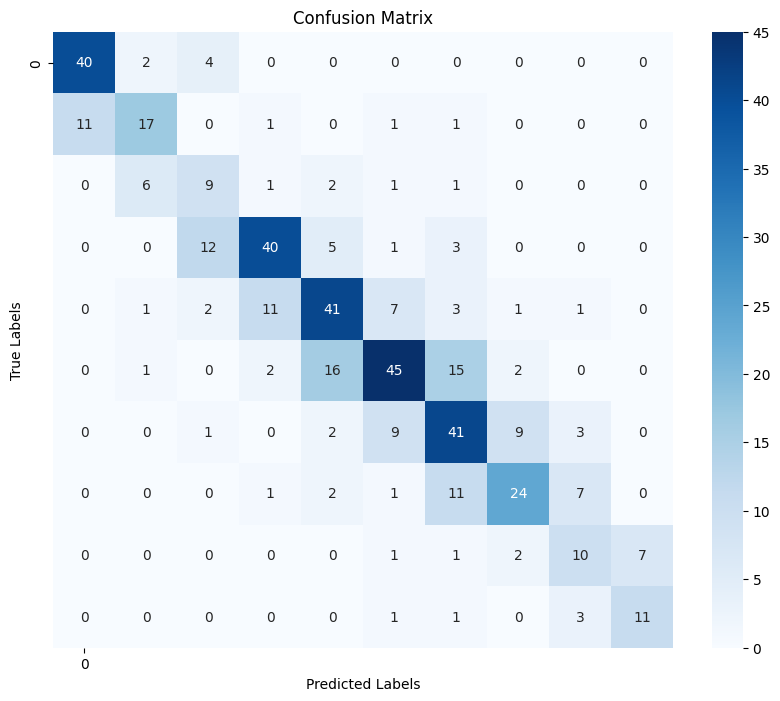

In [73]:
model = TwoBertEssayScorer(
    bert_model_name=BERT_MODEL_NAME,
    hidden_dim=HIDDEN_DIM,
    output_dim=1,
    dropout_rate=DROPOUT_RATE,
).to(device)

# Load the best model checkpoint
model.load_state_dict(
    torch.load("../checkpoints/model_epoch_7_loss_3.7731.pt", weights_only=False)[
        "model_state_dict"
    ]
)
test_dataset = EssayDataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
accuracy, report, cm = evaluate_regression_as_classification(
    model, test_dataloader, device
)

print(f"Accuracy: {accuracy}")
print("\n Report:")
print(report)

confusion_matrix_plot(cm, OUTPUT_DIM)

# Cross-Attention Architecture

---

Enhance the two-BERT model with cross-attention mechanisms to allow prompts and essays to attend to each other.

## Define Cross-Attention Two-BERT Model

Implement a model-architecture where prompt and essay representations interact through multi-head cross-attention.

In [10]:
class TwoBertEssayScorerCrossAttention(nn.Module):
    """
    A model-architecture where prompt and essay representations interact through multi-head cross-attention.
    """
    
    def __init__(
        self,
        bert_model_name="bert-base-uncased",
        hidden_dim=256,
        output_dim=1,
        dropout_rate=0.1,
        num_attention_heads=8,
    ):
        """
        Initialize the cross-attention two-BERT model.

        Args:
            bert_model_name (str): The name of the BERT model to use.
            hidden_dim (int): The hidden dimension of the model.
            output_dim (int): The output dimension of the model.
            dropout_rate (float): The dropout rate of the model.
            num_attention_heads (int): The number of attention heads of the model.
        """
        super(TwoBertEssayScorerCrossAttention, self).__init__()

        self.prompt_bert = BertModel.from_pretrained(bert_model_name)
        self.essay_bert = BertModel.from_pretrained(bert_model_name)
        self.tokenizer = BertTokenizer.from_pretrained(bert_model_name)

        bert_hidden_dim = self.prompt_bert.config.hidden_size

        # Cross-attention mechanism
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=bert_hidden_dim,
            num_heads=num_attention_heads,
            dropout=dropout_rate,
            batch_first=True,
        )

        # Layer normalization and dropout
        self.layer_norm = nn.LayerNorm(bert_hidden_dim * 2)
        self.dropout = nn.Dropout(dropout_rate)

        # Prediction head
        self.prediction_head = nn.Sequential(
            nn.Linear(bert_hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, prompt_texts, essay_texts, max_length=512):
        """
        Forward pass for the cross-attention two-BERT model.

        Args:
            prompt_texts (str): The prompt texts.
            essay_texts (str): The essay texts.
            max_length (int): The maximum length of the input sequence.

        Returns:
            torch.Tensor: The predicted score.
        """
        # Tokenize prompts
        prompt_inputs = self.tokenizer(
            prompt_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        prompt_input_ids = prompt_inputs["input_ids"].to(self.prompt_bert.device)
        prompt_attention_mask = prompt_inputs["attention_mask"].to(
            self.prompt_bert.device
        )

        # Tokenize essays
        essay_inputs = self.tokenizer(
            essay_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        essay_input_ids = essay_inputs["input_ids"].to(self.essay_bert.device)
        essay_attention_mask = essay_inputs["attention_mask"].to(self.essay_bert.device)

        # Get sequence representations
        prompt_outputs = self.prompt_bert(
            input_ids=prompt_input_ids,
            attention_mask=prompt_attention_mask,
            return_dict=True,
        )
        essay_outputs = self.essay_bert(
            input_ids=essay_input_ids,
            attention_mask=essay_attention_mask,
            return_dict=True,
        )

        prompt_cls = prompt_outputs.last_hidden_state[
            :, 0, :
        ]  # [batch_size, hidden_dim]
        essay_cls = essay_outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_dim]

        # Cross-attention: prompt attends to essay
        attended_prompt, _ = self.cross_attention(
            query=prompt_cls.unsqueeze(1),
            key=essay_outputs.last_hidden_state,
            value=essay_outputs.last_hidden_state,
            key_padding_mask=~essay_attention_mask.bool(),
        )

        # Cross-attention: essay attends to prompt
        attended_essay, _ = self.cross_attention(
            query=essay_cls.unsqueeze(1),
            key=prompt_outputs.last_hidden_state,
            value=prompt_outputs.last_hidden_state,
            key_padding_mask=~prompt_attention_mask.bool(),
        )

        attended_prompt = attended_prompt.squeeze(1)
        attended_essay = attended_essay.squeeze(1)

        # Concatenate the attended representations
        combined_embedding = torch.cat((attended_prompt, attended_essay), dim=1)

        # Layer normalization and dropout
        combined_embedding = self.layer_norm(combined_embedding)
        combined_embedding = self.dropout(combined_embedding)

        # Pass through prediction head
        scores = self.prediction_head(combined_embedding)

        return scores

## Train Cross-Attention Model

In [75]:
# Hyperparameter tuning: trial_19_lr7.17e-05_wr0.32_hd1024_dr0.15-20250527_153210

BERT_MODEL_NAME = "bert-base-cased"
LEARNING_RATE = 7e-5
EPOCHS = 25
BATCH_SIZE = 8
MAX_LENGTH = 512  # BERT max length
HIDDEN_DIM = 1024
OUTPUT_DIM = 1
DROPOUT_RATE = 0.15
TENSORBOARD_LOG_DIR = "../runs/essay_scorer"
CHECKPOINT_DIR = "../checkpoints"
PATIENCE = 8  # Number of epochs to wait for improvement before stopping
DELTA = 0.001  # Minimum change to qualify as improvement
WARMUP_RATIO = 0.3
NUM_ATTENTION_HEADS = 8

model = TwoBertEssayScorerCrossAttention(
    bert_model_name=BERT_MODEL_NAME,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout_rate=DROPOUT_RATE,
    num_attention_heads=NUM_ATTENTION_HEADS,
).to(device)

# Create datasets
train_dataset = EssayDataset(train_df)
val_dataset = EssayDataset(val_df)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()

# Train
trained_model = train_regression_model(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    tensorboard_log_dir=TENSORBOARD_LOG_DIR,
    checkpoint_dir=CHECKPOINT_DIR,
    epochs=EPOCHS,
    patience=PATIENCE,
    delta=DELTA,
    max_length=MAX_LENGTH,
    warmup_ratio=WARMUP_RATIO,
)

TensorBoard logs will be saved to: ../runs/essay_scorer
Starting training...
Epoch 1/25, Batch 1/1487
Epoch 1/25, Batch 2/1487
Epoch 1/25, Batch 3/1487
Epoch 1/25, Batch 4/1487
Epoch 1/25, Batch 5/1487
Epoch 1/25, Batch 6/1487
Epoch 1/25, Batch 7/1487
Epoch 1/25, Batch 8/1487
Epoch 1/25, Batch 9/1487
Epoch 1/25, Batch 10/1487
Epoch 1/25, Batch 10/1487, Loss: 25.6127
Epoch 1/25, Batch 11/1487
Epoch 1/25, Batch 12/1487
Epoch 1/25, Batch 13/1487
Epoch 1/25, Batch 14/1487
Epoch 1/25, Batch 15/1487
Epoch 1/25, Batch 16/1487
Epoch 1/25, Batch 17/1487
Epoch 1/25, Batch 18/1487
Epoch 1/25, Batch 19/1487
Epoch 1/25, Batch 20/1487
Epoch 1/25, Batch 20/1487, Loss: 29.9082
Epoch 1/25, Batch 21/1487
Epoch 1/25, Batch 22/1487
Epoch 1/25, Batch 23/1487
Epoch 1/25, Batch 24/1487
Epoch 1/25, Batch 25/1487
Epoch 1/25, Batch 26/1487
Epoch 1/25, Batch 27/1487
Epoch 1/25, Batch 28/1487
Epoch 1/25, Batch 29/1487
Epoch 1/25, Batch 30/1487
Epoch 1/25, Batch 30/1487, Loss: 21.9662
Epoch 1/25, Batch 31/1487
Epo

/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Epoch 1/25 - Average Evaluation Loss: 3.9359
Epoch 1/25 - MSE: 3.9360, MAE: 1.5615, RMSE: 1.9839
Epoch 1/25 - R²: 0.3421, Pearson Correlation: 0.6141
Epoch 1/25 - Classification Accuracy: 0.2116
Validation loss improved from inf to 3.9359
Model saved to ../checkpoints/model_epoch_1_20250617_180318.pt
Epoch 2/25, Batch 1/1487
Epoch 2/25, Batch 2/1487
Epoch 2/25, Batch 3/1487
Epoch 2/25, Batch 4/1487
Epoch 2/25, Batch 5/1487
Epoch 2/25, Batch 6/1487
Epoch 2/25, Batch 7/1487
Epoch 2/25, Batch 8/1487
Epoch 2/25, Batch 9/1487
Epoch 2/25, Batch 10/1487
Epoch 2/25, Batch 10/1487, Loss: 1.7215
Epoch 2/25, Batch 11/1487
Epoch 2/25, Batch 12/1487
Epoch 2/25, Batch 13/1487
Epoch 2/25, Batch 14/1487
Epoch 2/25, Batch 15/1487
Epoch 2/25, Batch 16/1487
Epoch 2/25, Batch 17/1487
Epoch 2/25, Batch 18/1487
Epoch 2/25, Batch 19/1487
Epoch 2/25, Batch 20/1487
Epoch 2/25, Batch 20/1487, Loss: 2.7026
Epoch 2/25, Batch 21/1487
Epoch 2/25, Batch 22/1487
Epoch 2/25, Batch 23/1487
Epoch 2/25, Batch 24/1487
Epo

/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Epoch 2/25 - Average Evaluation Loss: 4.3164
Epoch 2/25 - MSE: 4.3306, MAE: 1.6357, RMSE: 2.0810
Epoch 2/25 - R²: 0.2761, Pearson Correlation: 0.6028
Epoch 2/25 - Classification Accuracy: 0.2099
No improvement in validation loss. Counter: 1/8
Epoch 3/25, Batch 1/1487
Epoch 3/25, Batch 2/1487
Epoch 3/25, Batch 3/1487
Epoch 3/25, Batch 4/1487
Epoch 3/25, Batch 5/1487
Epoch 3/25, Batch 6/1487
Epoch 3/25, Batch 7/1487
Epoch 3/25, Batch 8/1487
Epoch 3/25, Batch 9/1487
Epoch 3/25, Batch 10/1487
Epoch 3/25, Batch 10/1487, Loss: 3.4545
Epoch 3/25, Batch 11/1487
Epoch 3/25, Batch 12/1487
Epoch 3/25, Batch 13/1487
Epoch 3/25, Batch 14/1487
Epoch 3/25, Batch 15/1487
Epoch 3/25, Batch 16/1487
Epoch 3/25, Batch 17/1487
Epoch 3/25, Batch 18/1487
Epoch 3/25, Batch 19/1487
Epoch 3/25, Batch 20/1487
Epoch 3/25, Batch 20/1487, Loss: 2.8245
Epoch 3/25, Batch 21/1487
Epoch 3/25, Batch 22/1487
Epoch 3/25, Batch 23/1487
Epoch 3/25, Batch 24/1487
Epoch 3/25, Batch 25/1487
Epoch 3/25, Batch 26/1487
Epoch 3/25

/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/finnf/miniconda3/envs/testPt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Epoch 5/25 - Average Evaluation Loss: 4.4606
Epoch 5/25 - MSE: 4.4660, MAE: 1.6720, RMSE: 2.1133
Epoch 5/25 - R²: 0.2535, Pearson Correlation: 0.5817
Epoch 5/25 - Classification Accuracy: 0.1779
No improvement in validation loss. Counter: 4/8
Epoch 6/25, Batch 1/1487
Epoch 6/25, Batch 2/1487
Epoch 6/25, Batch 3/1487
Epoch 6/25, Batch 4/1487
Epoch 6/25, Batch 5/1487
Epoch 6/25, Batch 6/1487
Epoch 6/25, Batch 7/1487
Epoch 6/25, Batch 8/1487
Epoch 6/25, Batch 9/1487
Epoch 6/25, Batch 10/1487
Epoch 6/25, Batch 10/1487, Loss: 0.7527
Epoch 6/25, Batch 11/1487
Epoch 6/25, Batch 12/1487
Epoch 6/25, Batch 13/1487
Epoch 6/25, Batch 14/1487
Epoch 6/25, Batch 15/1487
Epoch 6/25, Batch 16/1487
Epoch 6/25, Batch 17/1487
Epoch 6/25, Batch 18/1487
Epoch 6/25, Batch 19/1487
Epoch 6/25, Batch 20/1487
Epoch 6/25, Batch 20/1487, Loss: 0.4173
Epoch 6/25, Batch 21/1487
Epoch 6/25, Batch 22/1487
Epoch 6/25, Batch 23/1487
Epoch 6/25, Batch 24/1487
Epoch 6/25, Batch 25/1487
Epoch 6/25, Batch 26/1487
Epoch 6/25

In [76]:
# Clear CUDA cache
del model
del train_loader
del val_loader
del train_dataset
del test_dataset
del criterion
del trained_model
del optimizer
gc.collect()
torch.cuda.empty_cache()

## Evaluate Cross-Attention Model

Accuracy: 0.8083700440528634

 Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88        46
           1       0.90      0.90      0.90        31
           2       0.79      0.75      0.77        20
           3       0.80      0.80      0.80        61
           4       0.80      0.84      0.82        67
           5       0.75      0.80      0.77        81
           6       0.81      0.80      0.81        65
           7       0.70      0.76      0.73        46
           8       0.85      0.81      0.83        21
           9       1.00      0.75      0.86        16

    accuracy                           0.81       454
   macro avg       0.84      0.80      0.82       454
weighted avg       0.81      0.81      0.81       454



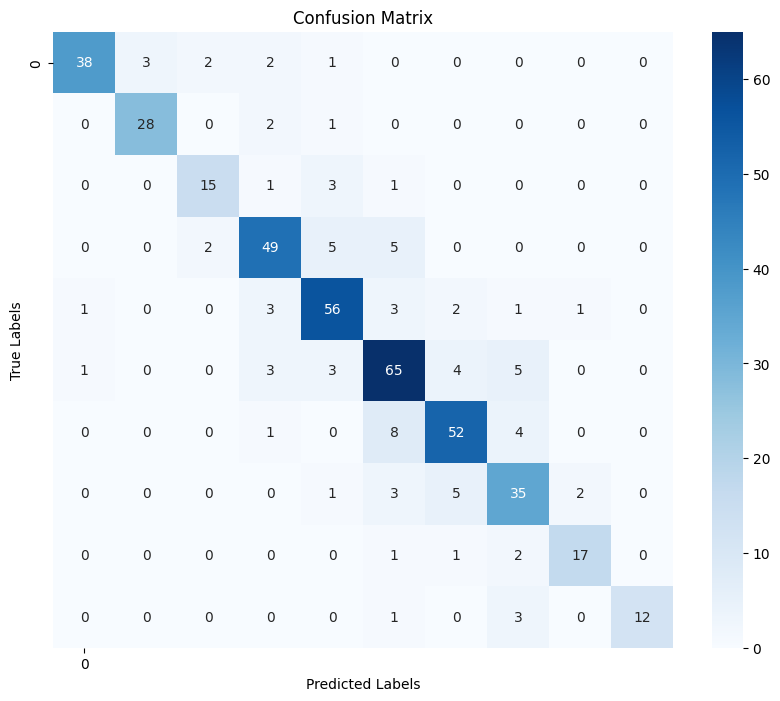

In [21]:
model = TwoBertEssayScorerCrossAttention(
    bert_model_name=BERT_MODEL_NAME,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout_rate=DROPOUT_RATE,
    num_attention_heads=NUM_ATTENTION_HEADS,
).to(device)

# Load the best model checkpoint
model.load_state_dict(
    torch.load("../checkpoints/model_epoch_24_20250530_144408.pt", weights_only=False)["model_state_dict"]
)
test_dataset = EssayDataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
accuracy, report, cm = evaluate_regression_as_classification(
    model, test_dataloader, device
)

print(f"Accuracy: {accuracy}")
print("\n Report:")
print(report)

confusion_matrix_plot(cm, OUTPUT_DIM)

### [`Click here to go back to the Homepage`](../Homepage.md)